In [1]:
import numpy as np
import pandas as pd
import matplotlib as mpl
import laplacejumps as lj
from tqdm.notebook import tqdm

In [2]:
%matplotlib inline
np.set_printoptions(precision=4)
pd.options.display.precision = 4
mpl.pyplot.style.use('seaborn-talk')

## First we import the and set the hyperparamters.

In [3]:
umm = pd.read_hdf('../data/clean/spy_2003-2019_1s.hdf').dropna()



In [5]:
returns = umm.groupby(pd.Grouper(freq='D')).transform(
    lambda x: x.diff()).dropna()

In [6]:
returns['2004-01-02']

date_time
2004-01-02 09:39:42    2.0577e-03
2004-01-02 10:14:21    8.9334e-04
2004-01-02 10:24:25    4.4637e-04
2004-01-02 10:25:10   -5.3567e-04
2004-01-02 10:34:07    8.9298e-05
2004-01-02 10:39:02    0.0000e+00
2004-01-02 11:00:24    1.1601e-03
2004-01-02 11:22:19    6.7172e-02
2004-01-02 11:26:45   -6.8689e-02
2004-01-02 11:35:08    8.0361e-04
2004-01-02 11:37:18   -1.7852e-04
2004-01-02 12:07:54   -1.4293e-03
2004-01-02 12:07:55    0.0000e+00
2004-01-02 12:21:00   -1.9687e-03
2004-01-02 12:21:04    0.0000e+00
2004-01-02 12:22:47    6.2682e-04
2004-01-02 12:42:29    8.9513e-05
2004-01-02 12:52:11   -3.5810e-04
2004-01-02 12:53:41    8.0555e-04
2004-01-02 13:08:13   -1.0742e-03
2004-01-02 13:24:19    6.2676e-04
2004-01-02 13:30:37    0.0000e+00
2004-01-02 13:36:17   -3.5810e-04
2004-01-02 13:59:47    8.9538e-05
2004-01-02 14:33:35   -3.3182e-03
2004-01-02 14:36:07    0.0000e+00
2004-01-02 14:39:30    4.6603e-03
2004-01-02 15:05:08   -8.3502e-03
2004-01-02 15:23:27   -1.1728e-03
2004

In [ ]:
#returns = pd.read_hdf('../results/spy_2003-2017_300ms_rtns.hdf', 'spy').groupby(
 #   pd.Grouper(freq='s')).sum(min_count=1).dropna()

In [7]:
returns.resample('D').sum(min_count=1).count()

4254

In [8]:
k = 1
p = 2
theta = .5
infill_dim = int(returns.groupby(pd.Grouper(freq='D')).count().median())
preaverage_dim = int(infill_dim**(11/20) * theta)
print(f"Preaverge_dim is {preaverage_dim}.")
kappa_const = 1000
kappa = int(kappa_const + infill_dim**(1/4))
print(f"Subsample_dim is {kappa}.")

Preaverge_dim is 94.
Subsample_dim is 1010.


## Compute the 5 minute versions

In [9]:
real_vol = returns.resample('5min').sum().groupby(pd.Grouper(freq='D')).agg(lj.real_vol)
bipower11_vol = returns.resample('5min').sum().groupby(pd.Grouper(freq='D')).agg(
    lambda x: lj.bipower(x, 1,1,1))

In [10]:
daily_rtn = returns.resample('D').sum()
daily_rtn.name = 'daily_rtn'
daily_rtn.to_frame().dropna().to_csv('../results/spy_daily_rtn_2003-2017.tmp.csv')

In [11]:
noise_vol_via_bipower = returns.groupby(pd.Grouper(freq='D')).agg(
    lambda x: -np.mean(x.values[1:] * x.values[:-1]) if x.size > 0 else np.nan)   

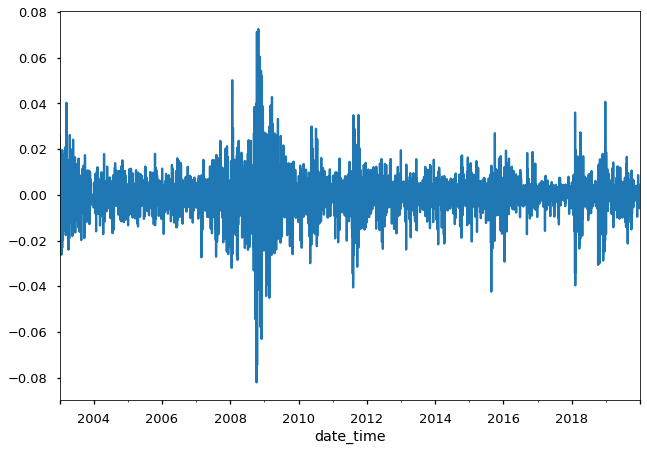

In [12]:
daily_rtn.plot()

In [13]:
returns.head()

date_time
2003-01-02 09:30:16    0.0000
2003-01-02 09:30:21    0.0008
2003-01-02 09:30:22    0.0000
2003-01-02 09:30:25    0.0003
2003-01-02 09:30:26    0.0000
Name: log_price, dtype: float64

In [14]:
noise_vol_via_bipower.head()

date_time
2003-01-02    3.9953e-08
2003-01-03    3.1345e-08
2003-01-04           NaN
2003-01-05           NaN
2003-01-06    3.1593e-08
Freq: D, Name: log_price, dtype: float64

In [15]:
noise_vol_via_bipower.mean() 

7.631446656481412e-08

# Compute the noise volatility and pre-average the data

In [16]:
noise_vol = pd.DataFrame(returns.groupby(pd.Grouper(freq='D')).apply(
    lambda x: lj.compute_noise_vol(x, preaverage_dim))).rename(
    columns={'log_price':'noise'}).dropna()

In [17]:
noise_vol.query('noise > noise.quantile(.999)')

noise
date_time             
2004-01-02  1.5088e-04
2004-03-15  9.2127e-06
2004-04-29  5.7240e-06
2004-05-12  6.1722e-06
2004-07-01  1.0915e-05

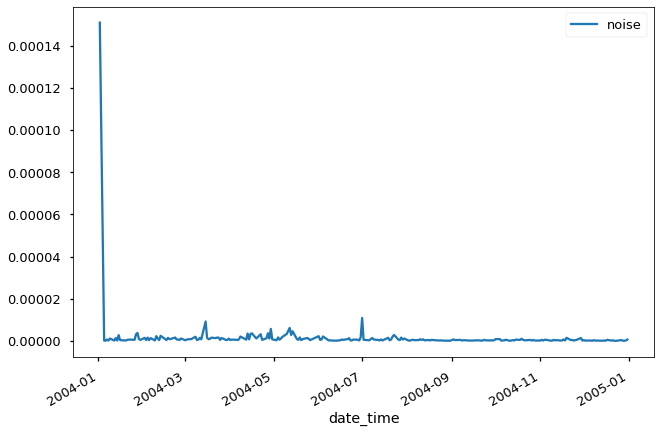

In [18]:
noise_vol.loc['2004'].plot()

In [19]:
psi2 = lj.compute_psi_vals(94)[1]
g_weights = np.asarray([lj.gfun(val / 94) for val in np.arange(1, 94 + 1)])


In [20]:
umm = returns['2004-06']

In [21]:
thing = lj.preaverage_data(umm, 94)

In [23]:
thing

Series([], Name: log_price, dtype: float64)

In [24]:
umm2 = umm['2004-06-01']

In [25]:
umm2

date_time
2004-06-01 10:10:33    0.0015
2004-06-01 10:41:40   -0.0022
2004-06-01 13:09:38   -0.0012
2004-06-01 13:10:37    0.0000
2004-06-01 14:25:49   -0.0024
2004-06-01 14:32:24   -0.0015
2004-06-01 14:44:50   -0.0002
2004-06-01 15:12:48    0.0023
2004-06-01 15:50:29    0.0048
2004-06-01 15:59:00   -0.0004
Name: log_price, dtype: float64

In [26]:
umm2.rolling(window=94, min_periods=94).mean()

date_time
2004-06-01 10:10:33   NaN
2004-06-01 10:41:40   NaN
2004-06-01 13:09:38   NaN
2004-06-01 13:10:37   NaN
2004-06-01 14:25:49   NaN
2004-06-01 14:32:24   NaN
2004-06-01 14:44:50   NaN
2004-06-01 15:12:48   NaN
2004-06-01 15:50:29   NaN
2004-06-01 15:59:00   NaN
Name: log_price, dtype: float64

In [29]:
thing

Series([], Name: log_price, dtype: float64)

In [31]:
preaveraged_data = pd.concat([lj.preaverage_data(group.dropna(), preaverage_dim)
                              for _, group in tqdm(returns.groupby(pd.Grouper(freq='M')))],
                             axis=0).dropna()

In [32]:
preaverage_dim

94

In [33]:
preaveraged_data.count()

60274170

In [34]:
preaveraged_data.describe()

count    6.0274e+07
mean     6.1094e-08
std      7.2094e-05
min     -3.7519e-03
25%     -2.8799e-05
50%      3.4105e-07
75%      2.8964e-05
max      3.7652e-03
Name: log_price, dtype: float64

##  Instantaneous Estimates

In [35]:
vol_est = lj.compute_instantaneous_vol(preaveraged_data, infill_dim=infill_dim, kappa=kappa)

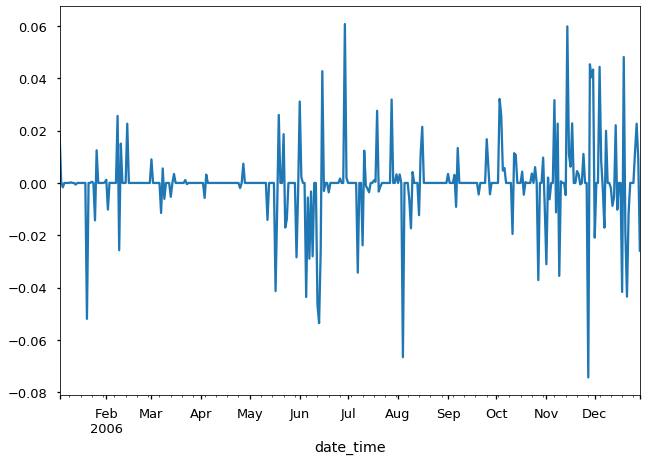

In [36]:
preaveraged_data.loc['2006'].resample('D').sum().plot()

## Daily Estimates

In [37]:
discrete_vol_est = vol_est.groupby(pd.Grouper(freq='D')).mean().dropna()

In [38]:
discrete_vol_est

absolute   diffusion       jumps
0                                           
2003-01-02    0.0103  1.0551e-04  1.1088e-04
2003-01-03    0.0102  1.0082e-04  7.8404e-05
2003-01-06    0.0080  6.2076e-05  5.0092e-05
2003-01-07    0.0102  1.0035e-04  7.1608e-05
2003-01-08    0.0096  8.2777e-05  7.5033e-05
...              ...         ...         ...
2019-12-24    0.0013  1.5298e-06  1.2696e-06
2019-12-26    0.0013  9.7574e-07  2.2156e-06
2019-12-27    0.0020  4.1276e-06  4.9016e-06
2019-12-30    0.0028  5.9412e-06  9.4783e-06
2019-12-31    0.0021  3.2182e-06  5.4836e-06

[3500 rows x 3 columns]

In [39]:
bipower_vol = lj.bipower_for_df(preaveraged_data)

AttributeError: 'DataFrame' object has no attribute 'clip_lower'

## Plot the Data

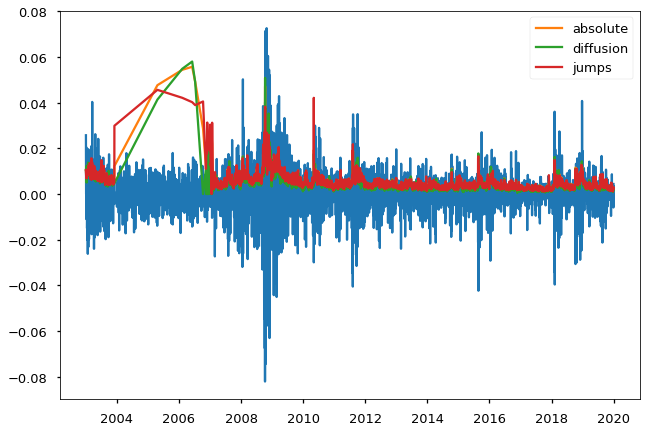

In [40]:
daily_fig, daily_ax = mpl.pyplot.subplots()
daily_ax.plot(daily_rtn)
for name, vol in discrete_vol_est.items():
    if name != 'absolute':
        daily_ax.plot(np.sqrt(vol), label=name, zorder=20)
    else:
        daily_ax.plot(vol, label=name, zorder=10)
daily_ax.legend()

## Save the results

In [48]:
with pd.HDFStore(f'../results/spy_daily_estimates_2017-2019_{kappa_const}_1sec.hdf') as volatility_store:
    volatility_store['daily_rtn'] = daily_rtn.to_frame().query('index >= @pd.to_datetime("2017-01-01")')
    volatility_store['discrete_vol_est'] = discrete_vol_est.query('index >= @pd.to_datetime("2017-01-01")')

In [ ]:
with pd.HDFStore(f'../results/spy_5min_estimates_2003-2019.tmp.hdf') as volatility_store:
    volatility_store['real_vol'] = real_vol
    volatility_store['bipower11_vol'] = bipower11_vol
    volatility_store['bipower_jump_vol'] = np.maximum(real_vol - bipower11_vol, 0)

In [ ]:
with pd.HDFStore(f'../results/spy_daily_estimates_2003-2019_{kappa_const}_1sec.tmp.hdf') as volatility_store:
    volatility_store['daily_rtn'] = daily_rtn
    volatility_store['discrete_vol_est'] = discrete_vol_est
    volatility_store['bipower_vol'] = bipower_vol

In [ ]:
with pd.HDFStore(f'../results/spy_local_estimates_2003-2019_{kappa_const}_1sec.tmp.hdf') as volatility_store:
    volatility_store['local_vol_est'] = vol_est
    volatility_store['log_prices'] = returns
    volatility_store['preaveraged_data'] = preaveraged_data